In [149]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import napari
import math
import cv2

In [150]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [151]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
donors = [
    # "LN Donor A",
    # "LN Donor E",
    # "INT Donor B",
    # "INT Donor E",
    "TS Donor A",
    # "TS Donor E",
]


# Read clustered data

In [153]:
# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

In [154]:
masks_follicle = get_masks(data_dir / 'masks_follicle')


In [155]:
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [156]:
adata = adata[adata.obs.Dataset.isin(donors)]

In [157]:
adatas = []
for d in donors:
    adata_d = adata[adata.obs.Dataset == d]
    mask_d = masks_follicle[d]
    centroids = adata_d.obsm['spatial'].astype(int)
    x_max, y_max = centroids.max(axis=0)
    
    # Pad mask if needed
    pad_bottom = int(np.ceil(y_max)) - mask_d.shape[0]+1
    pad_right = int(np.ceil(x_max)) - mask_d.shape[1]+1
    pad_bottom = 0 if pad_bottom < 0 else pad_bottom
    pad_right = 0 if pad_right < 0 else pad_right
    mask_d_padded = cv2.copyMakeBorder(mask_d, 0, pad_bottom, 0, pad_right, 
                                       cv2.BORDER_CONSTANT, value=0)
    
    # Extract follicle region
    indices_foll = mask_d_padded[centroids[:,1],centroids[:,0]] > 0
    adata_d_foll = adata_d[indices_foll]
    adatas.append(adata_d_foll)


In [158]:
adata_foll = ad.concat(adatas)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Phenotype']`


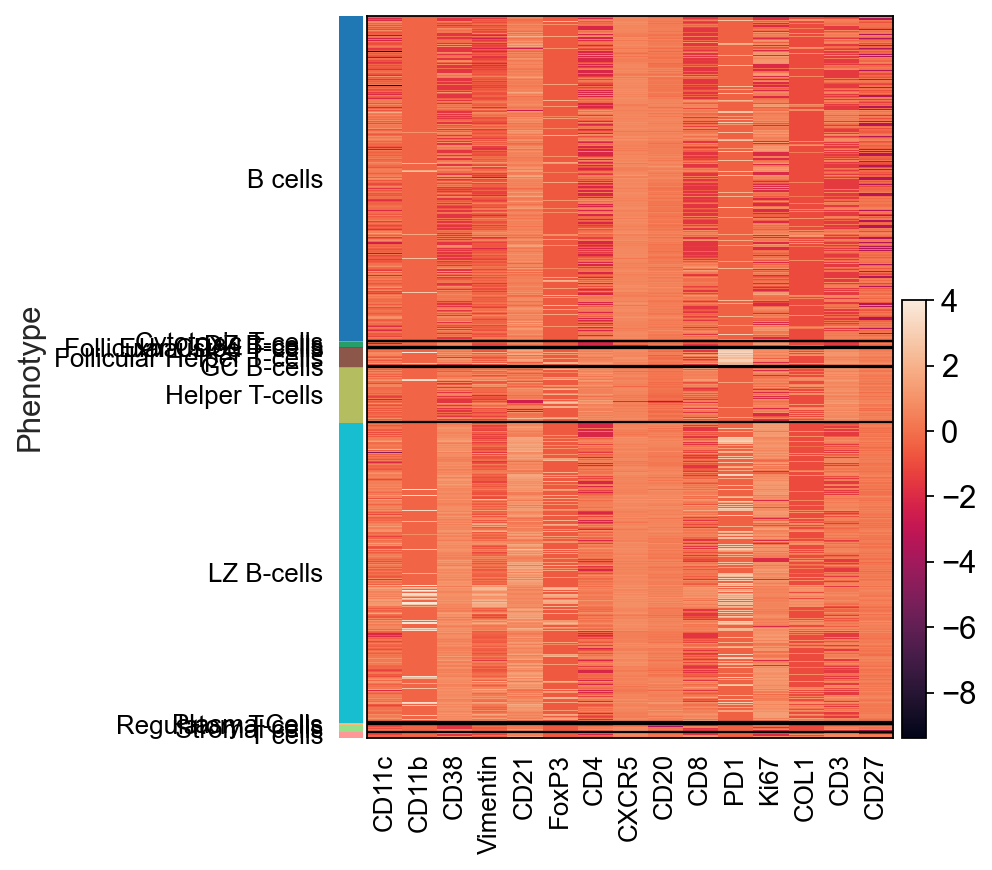

In [159]:
adata_foll.obs['Phenotype'] = adata_foll.obs['Phenotype'].astype('category')
sc.tl.dendrogram(adata_foll, groupby='Phenotype')
sc.pl.heatmap(adata_foll, adata_foll.var_names, groupby='Phenotype')

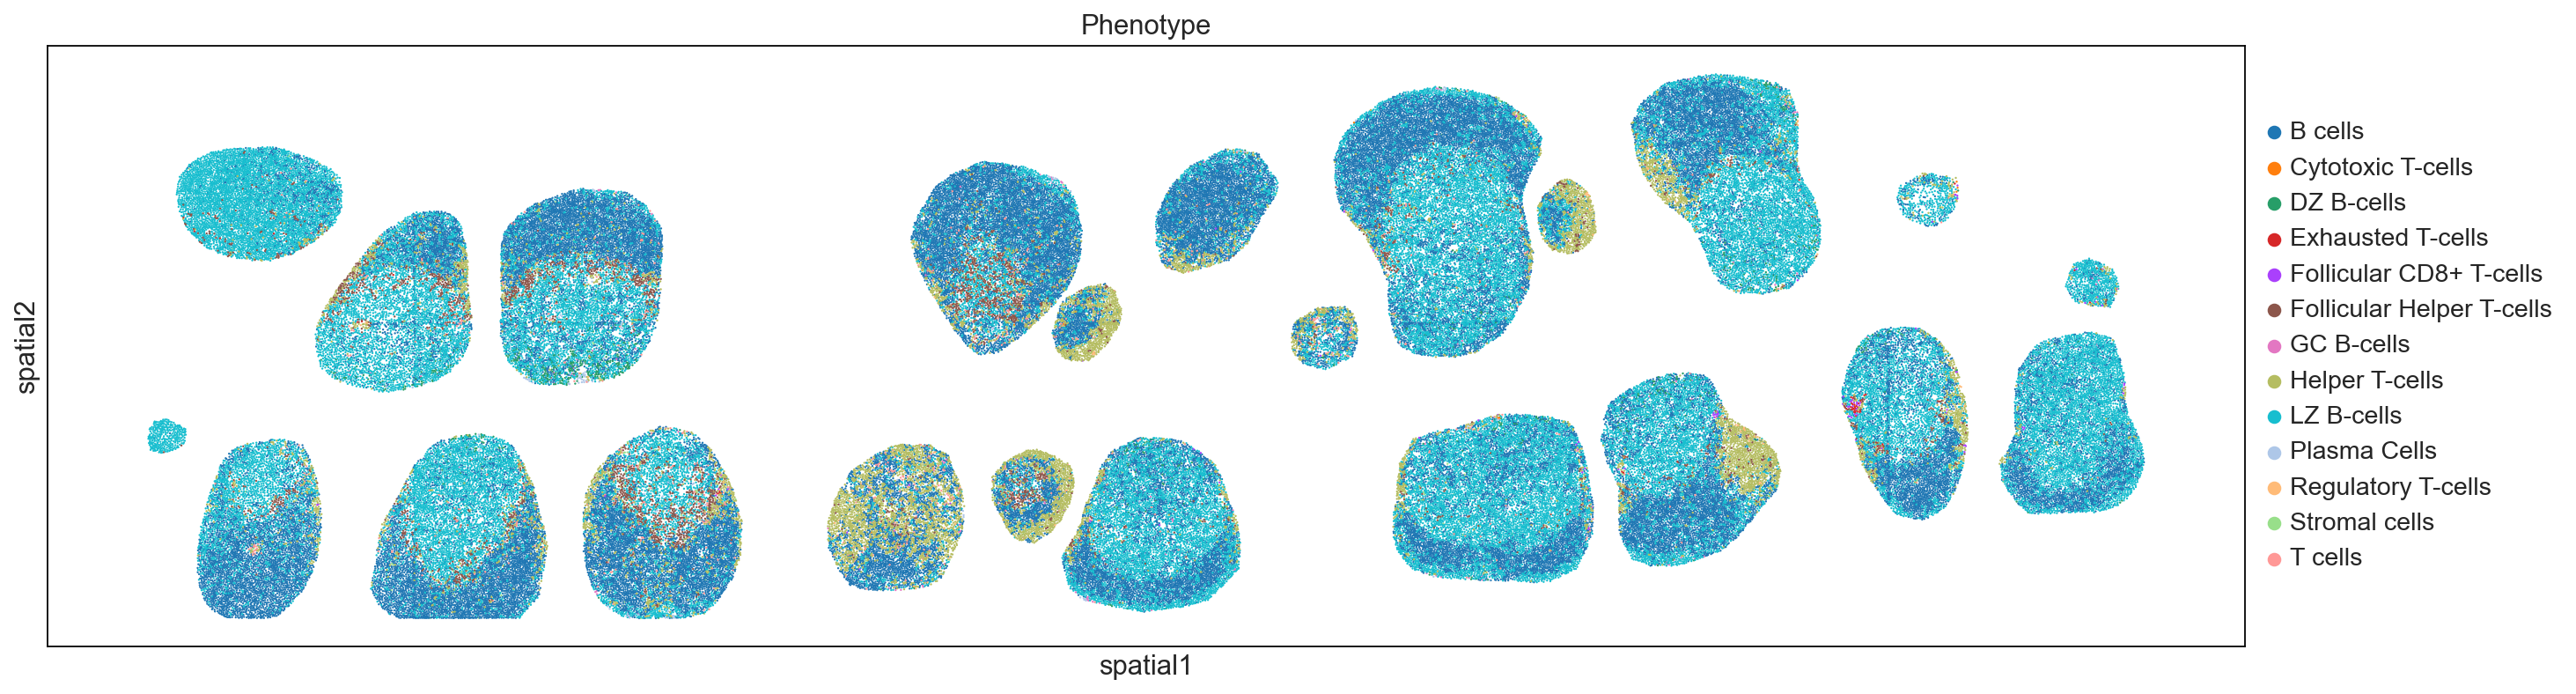

In [160]:
fig, ax = plt.subplots(figsize=(20,20))
sc.pl.spatial(adata_foll[adata_foll.obs.Dataset == "TS Donor A"], color='Phenotype', ax=ax, spot_size=7, )

# Read COL images

In [162]:
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries


def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_streching(img):
    p2, p98 = np.percentile(img, (1, 99))
    return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255))

def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

def get_img_subset(imgs, markers, labels):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(imgs[idx])
    return np.stack(imgs_subset, axis=2)

In [163]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [164]:
size = 1000 
imgs_col = []

# Read COL1 images
for donor in donors:
    h5_data = p_dir / "data" / "h5_new" / f"{donor}.hdf5"
    
    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_col = np.zeros((y_max, x_max), dtype=np.uint8)

    ROIs = [i for i in range(1, 21)]
    for roi in tqdm(ROIs):
        if roi not in arrangement[donor].keys():
            continue

        # Read imgs
        imgs, labels = get_imgs(h5_data, str(roi))

        # Get multiplex image
        data = get_img_subset(imgs, ['COL1'], labels)

        # Insert Combined images
        y = arrangement[donor][roi][0]
        x = arrangement[donor][roi][1]
        img_col[y : y + size, x : x + size] = data[:1000,:1000].squeeze()

    img_col= contrast_streching(img_col)
    imgs_col.append(img_col)

  0%|          | 0/20 [00:00<?, ?it/s]

# Plot COL with BT cells

In [165]:
import matplotlib 
from PIL import Image

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],4), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def get_contour(mask: np.ndarray):
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [171]:
masks = {}
for d in donors:
    masks[d] = get_masks(data_dir / "masks - Copy" / d)

In [172]:
colors = adata_foll.uns["Phenotype_colors"]
labels = adata_foll.obs.Phenotype.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = np.concatenate([colors_rgb, np.ones((len(colors_rgb), 1))*255], axis=1)
colors_rgb = colors_rgb.astype(np.uint8)

In [173]:
imgs_BT = []
imgs_back = []

for d in donors:
    adata_donor = adata_foll[adata_foll.obs.Dataset == d, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[d])
    img_combined = np.zeros((y_max, x_max, 4), dtype=np.uint8)
    img_background = np.zeros((y_max, x_max), dtype=np.uint8)
    
    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[d].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]

        # Get mask
        mask = masks[d][str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs.Phenotype == l].obs.Cell_label.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[d][i][0] - 1)
        x = max(0, arrangement[d][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img
        img_background[y : y + size, x : x + size] = mask > 0
    imgs_back.append(img_background)
    imgs_BT.append(img_combined)

In [174]:
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0, ncolors)

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)


IndexError: list index out of range

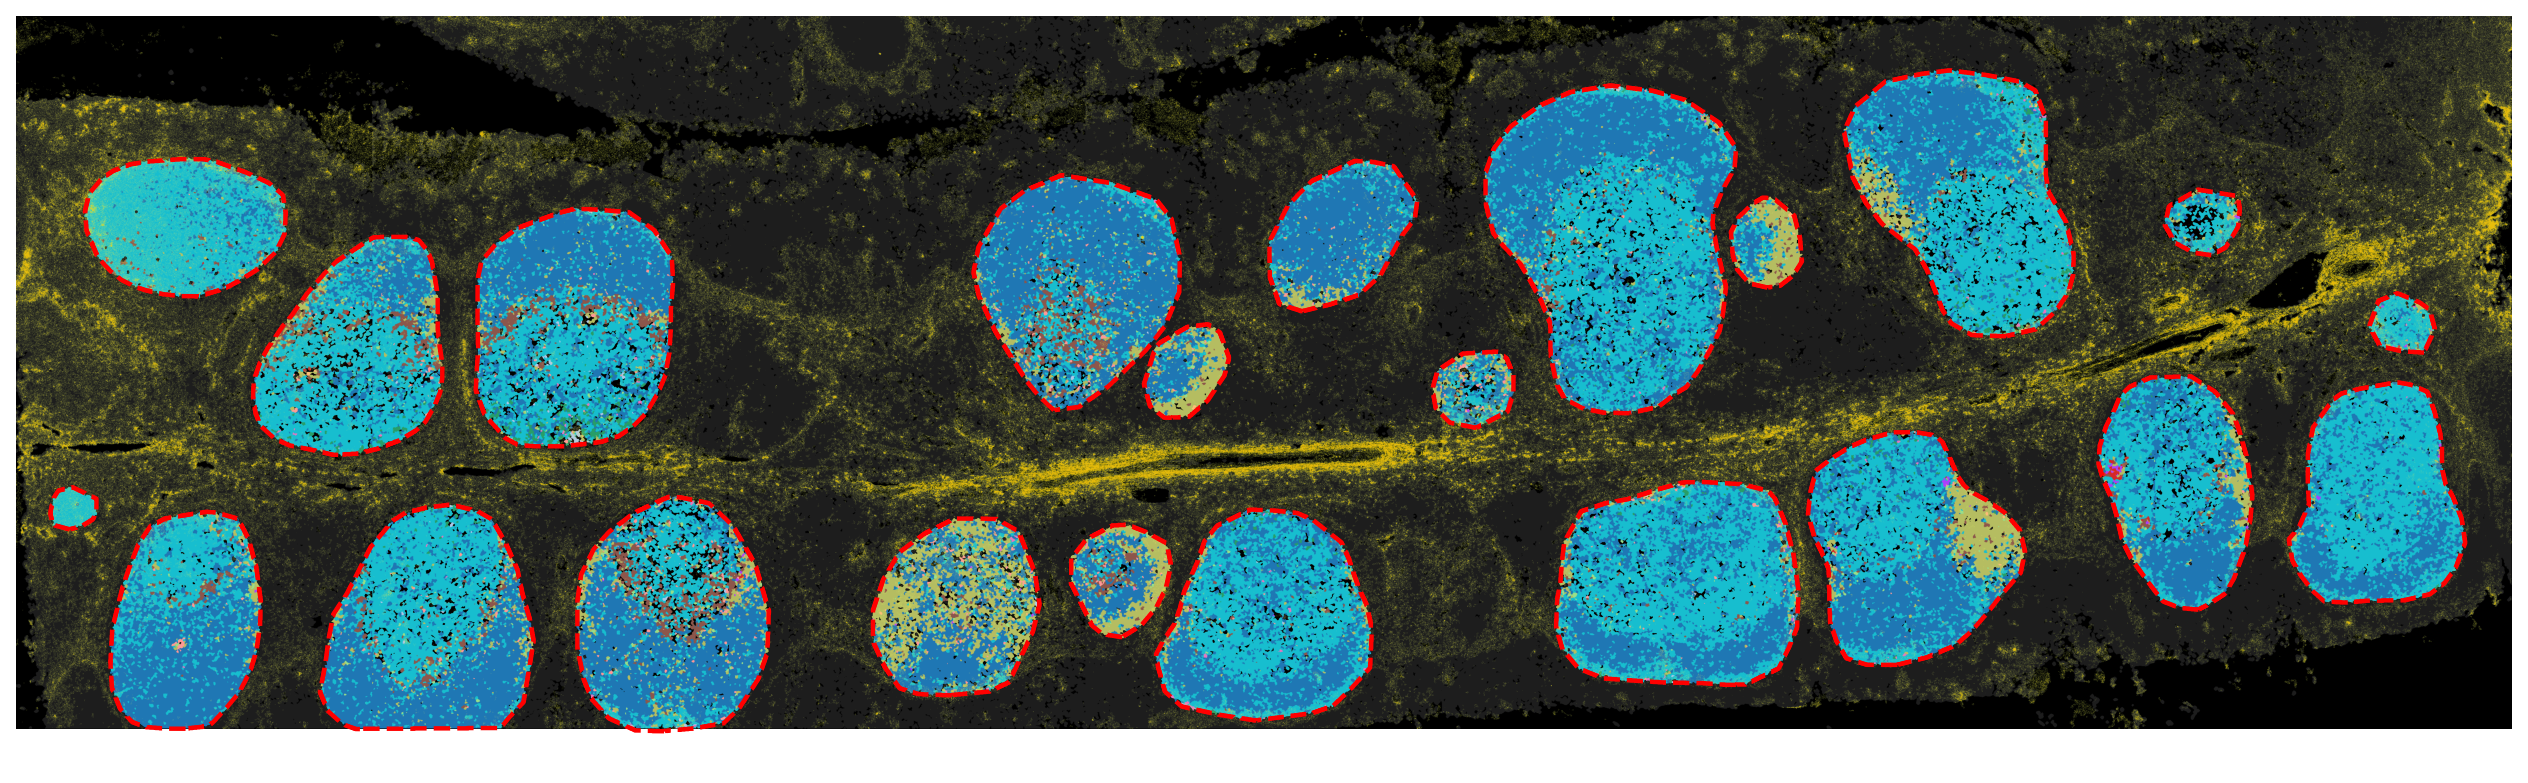

In [175]:
sns.set_style('white')

for i in range(1):
    img_col = imgs_col[i]
    img_bt = imgs_BT[i]
    img_back = imgs_back[i]
    
    mask = masks_follicle[donors[i]]
    contours = get_contour(mask)
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.imshow(img_back, cmap='Greys_r', vmin=0, vmax=10)
    ax.imshow(img_bt)
    ax.imshow(img_col, cmap=mycmap, alpha=0.9) 
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="red", linestyle='dashed')
    ax.axis('off')


(-0.5, 6999.5, 2106.535, -0.5)

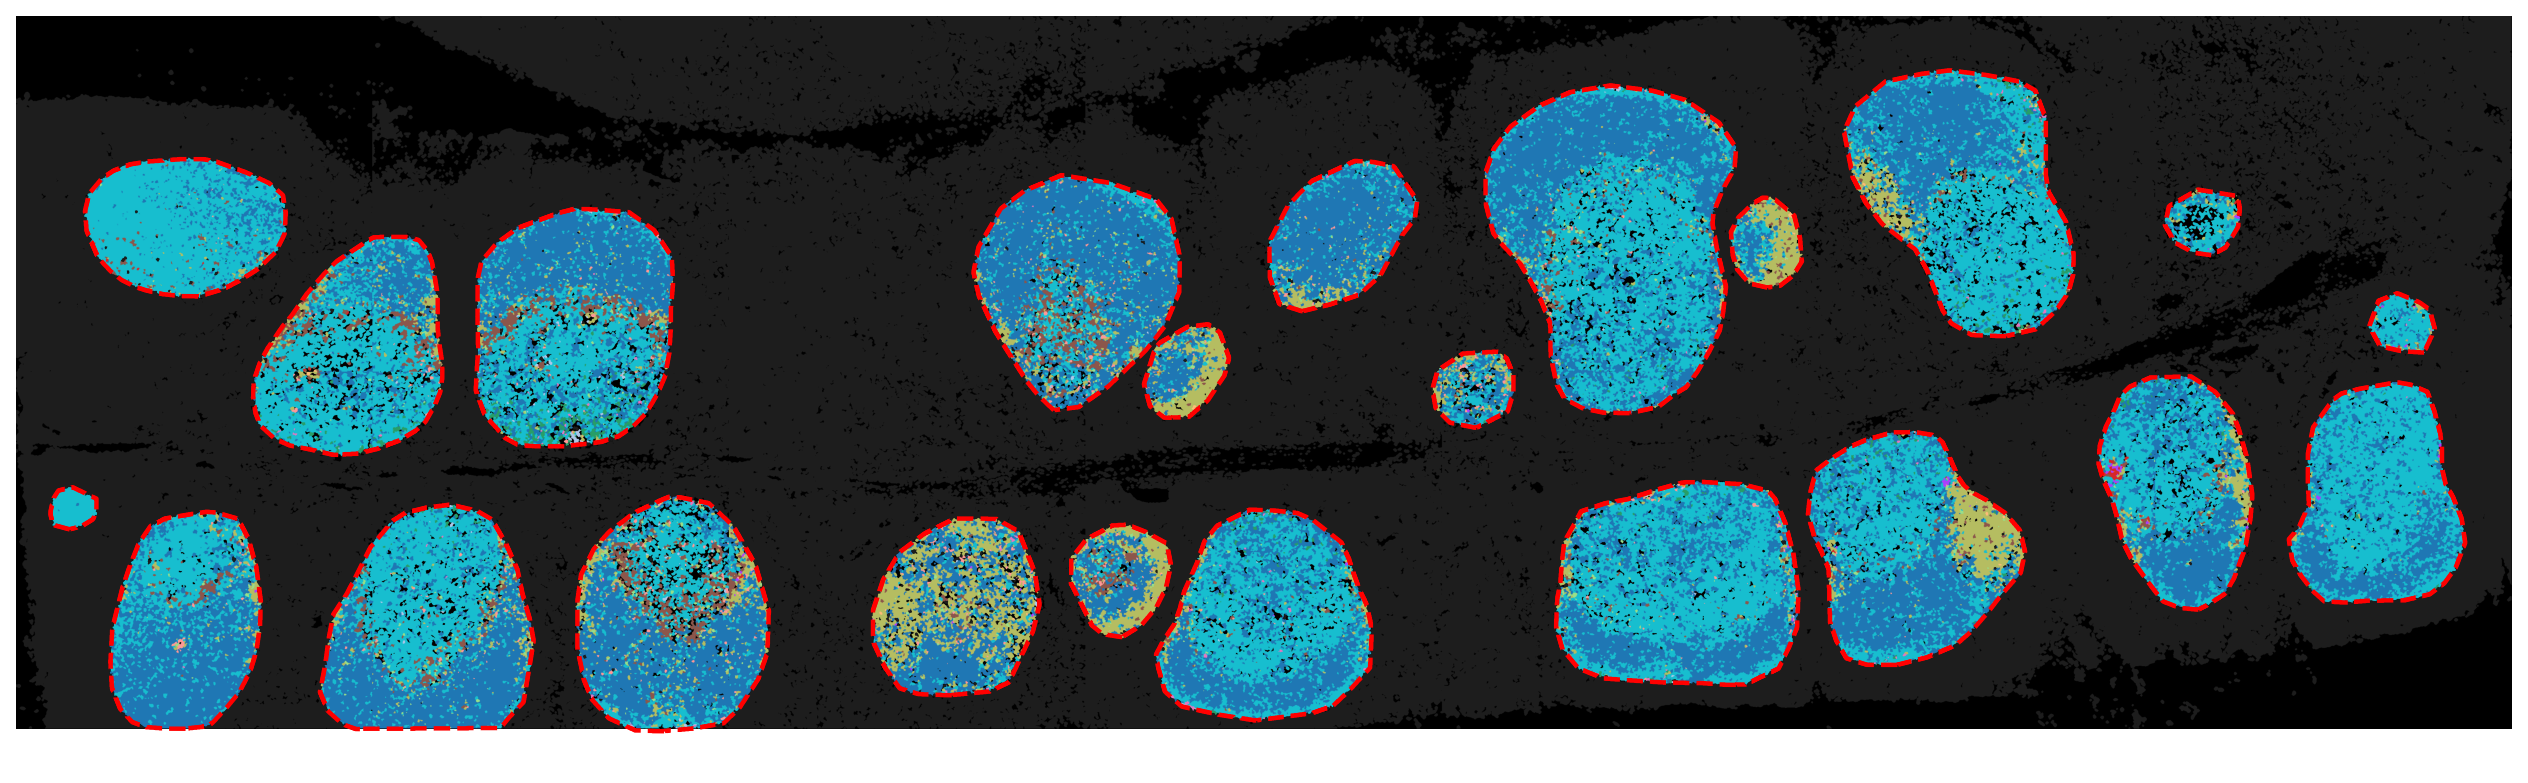

In [177]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_back, cmap='Greys_r', vmin=0, vmax=10)
ax.imshow(img_bt)
for j, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="red", linestyle='dashed')
ax.axis('off')


# Quant 

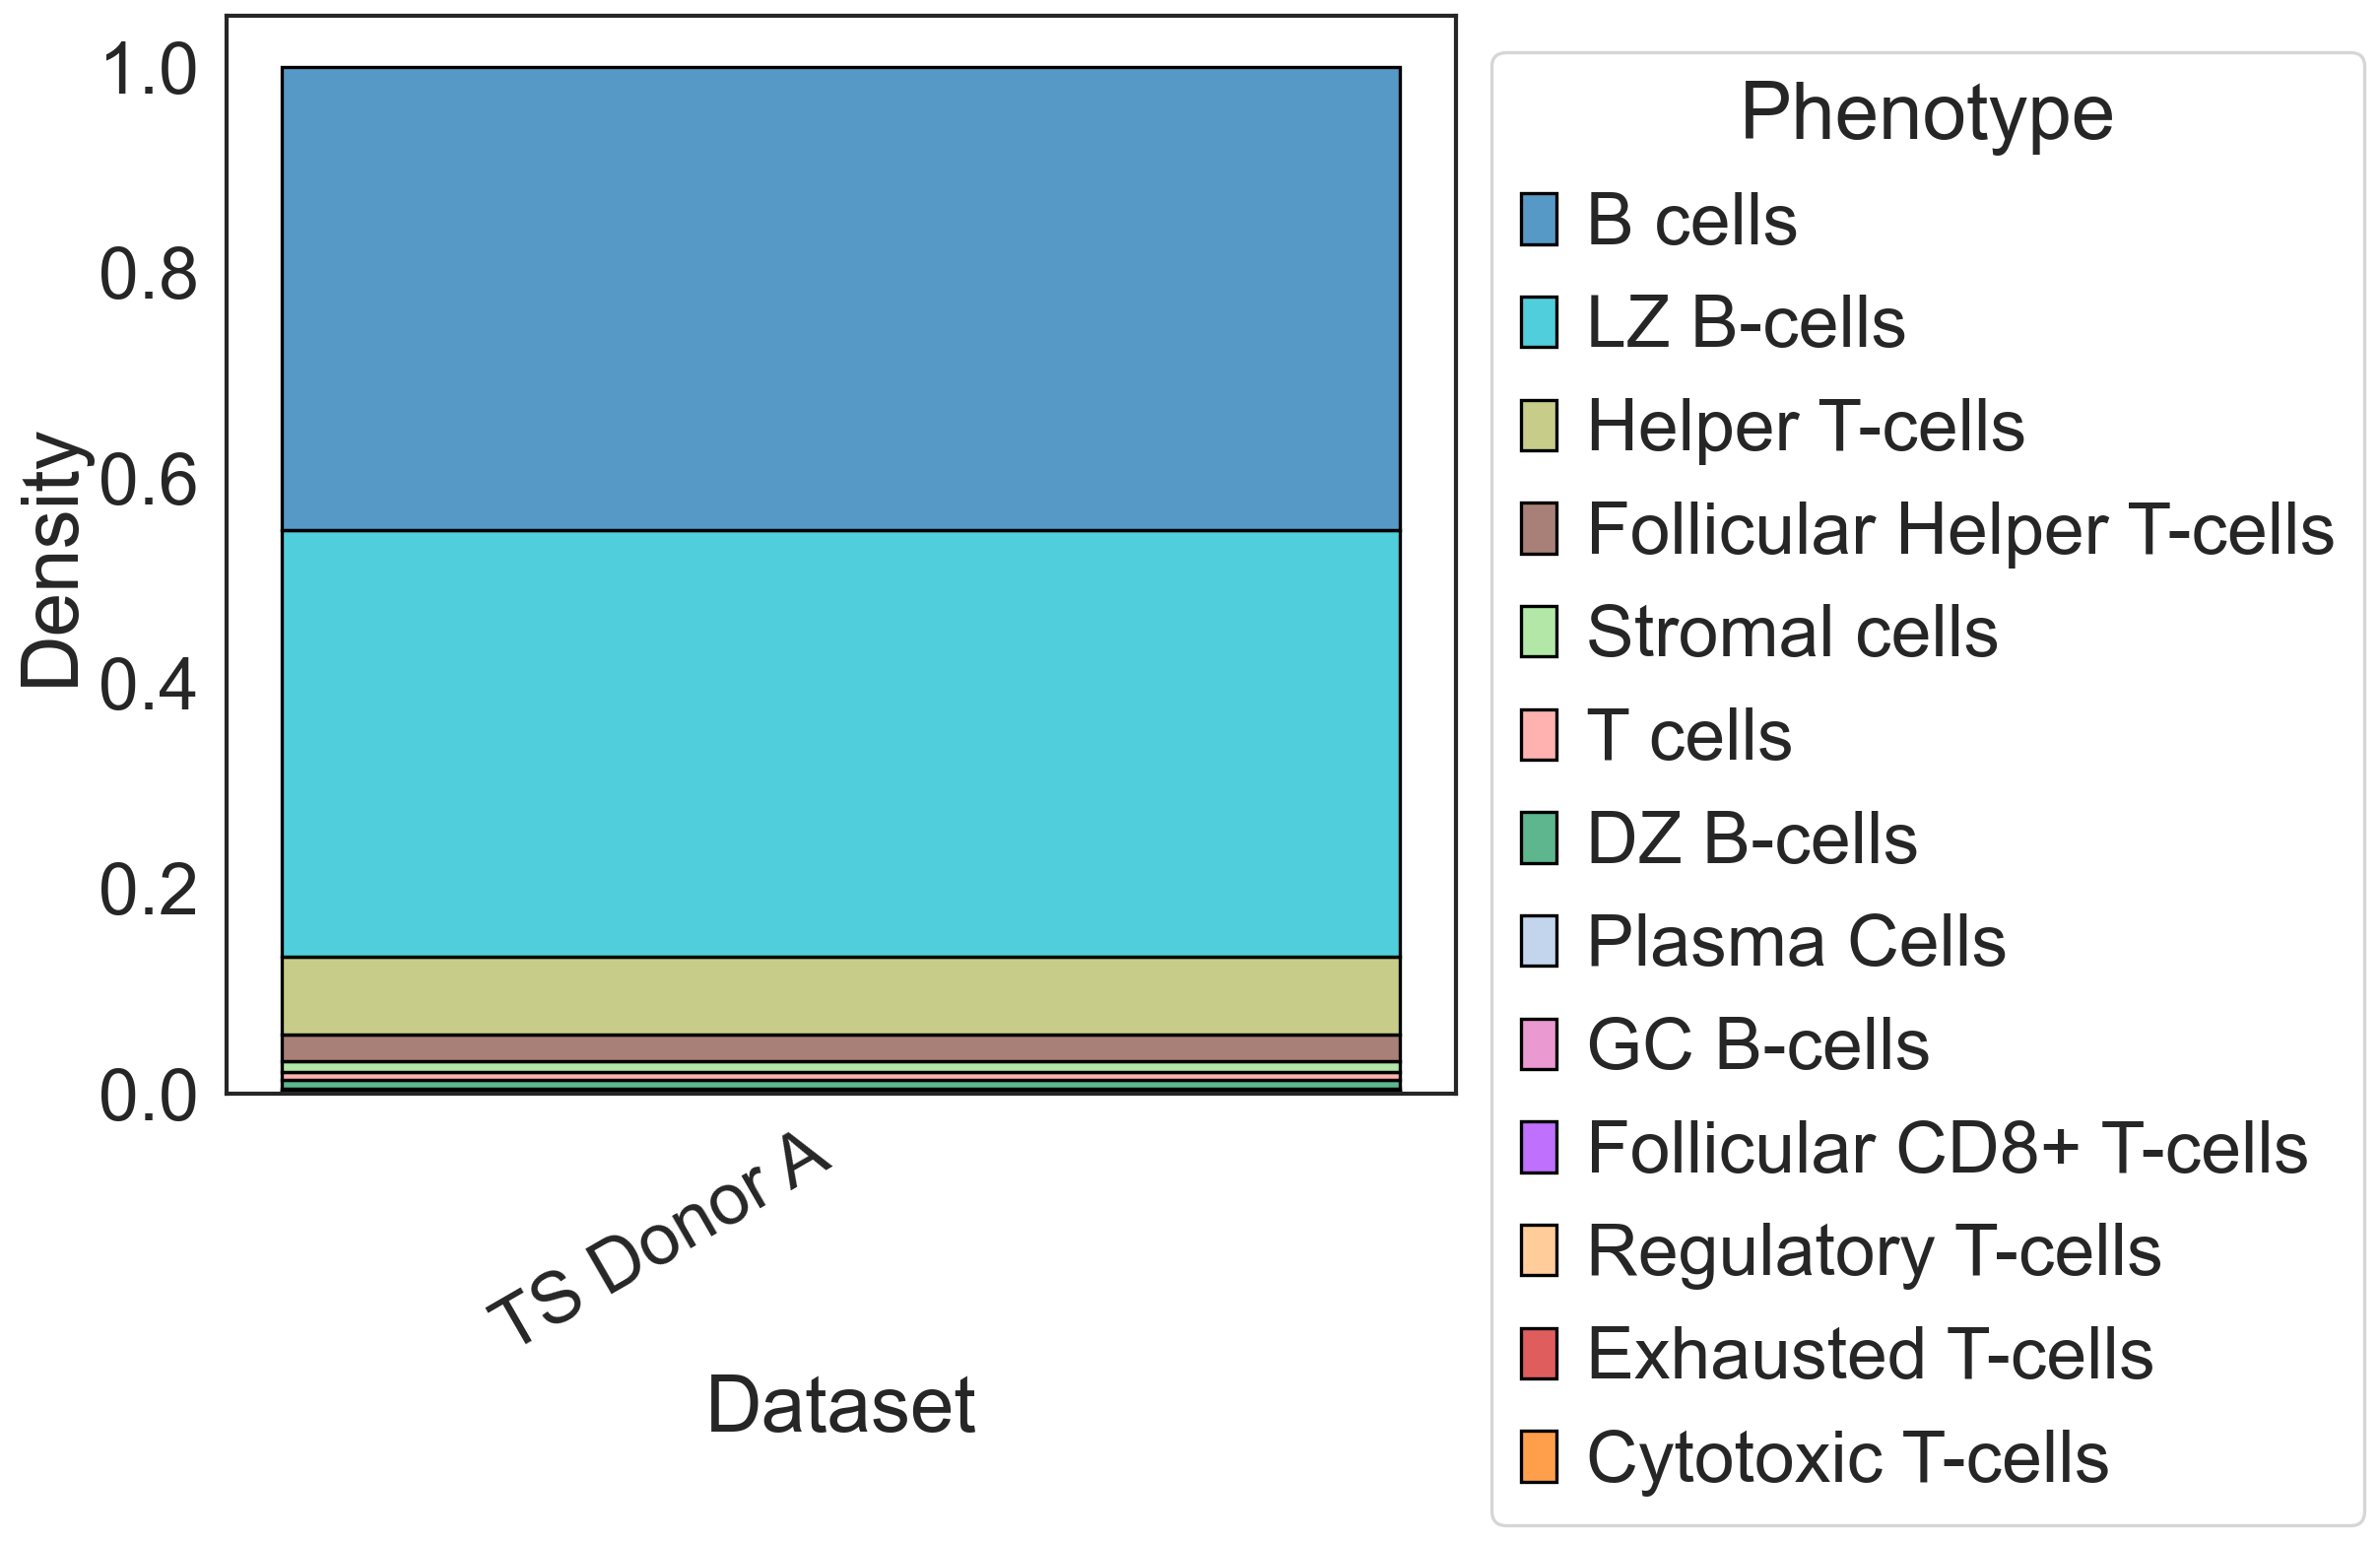

In [186]:
# Per Tissue phenotype composition

var = 'Phenotype' 
df_cluster = pd.DataFrame()
df_cluster["Dataset"] = adata_foll.obs['Dataset'].tolist()
df_cluster["Dataset"] = df_cluster["Dataset"].astype(str).astype('category')
df_cluster[var] = adata_foll.obs['Phenotype'].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()
df_cluster_count['Density'] = df_cluster_count.groupby("Dataset")["counts"].apply(lambda x: x / x.sum())

# Get cluster color matching heatmap
cluster_label_order = adata_foll.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_foll.uns[f"{var}_colors"]
labels = adata_foll.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

# plot stacked barplot
sns.set_style('white')
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax = sns.histplot(data=df_cluster_count, x="Dataset" , hue=var, weights='Density', discrete=True, multiple='stack', shrink=0.8, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))
    plt.xticks(rotation=30, ha='right')


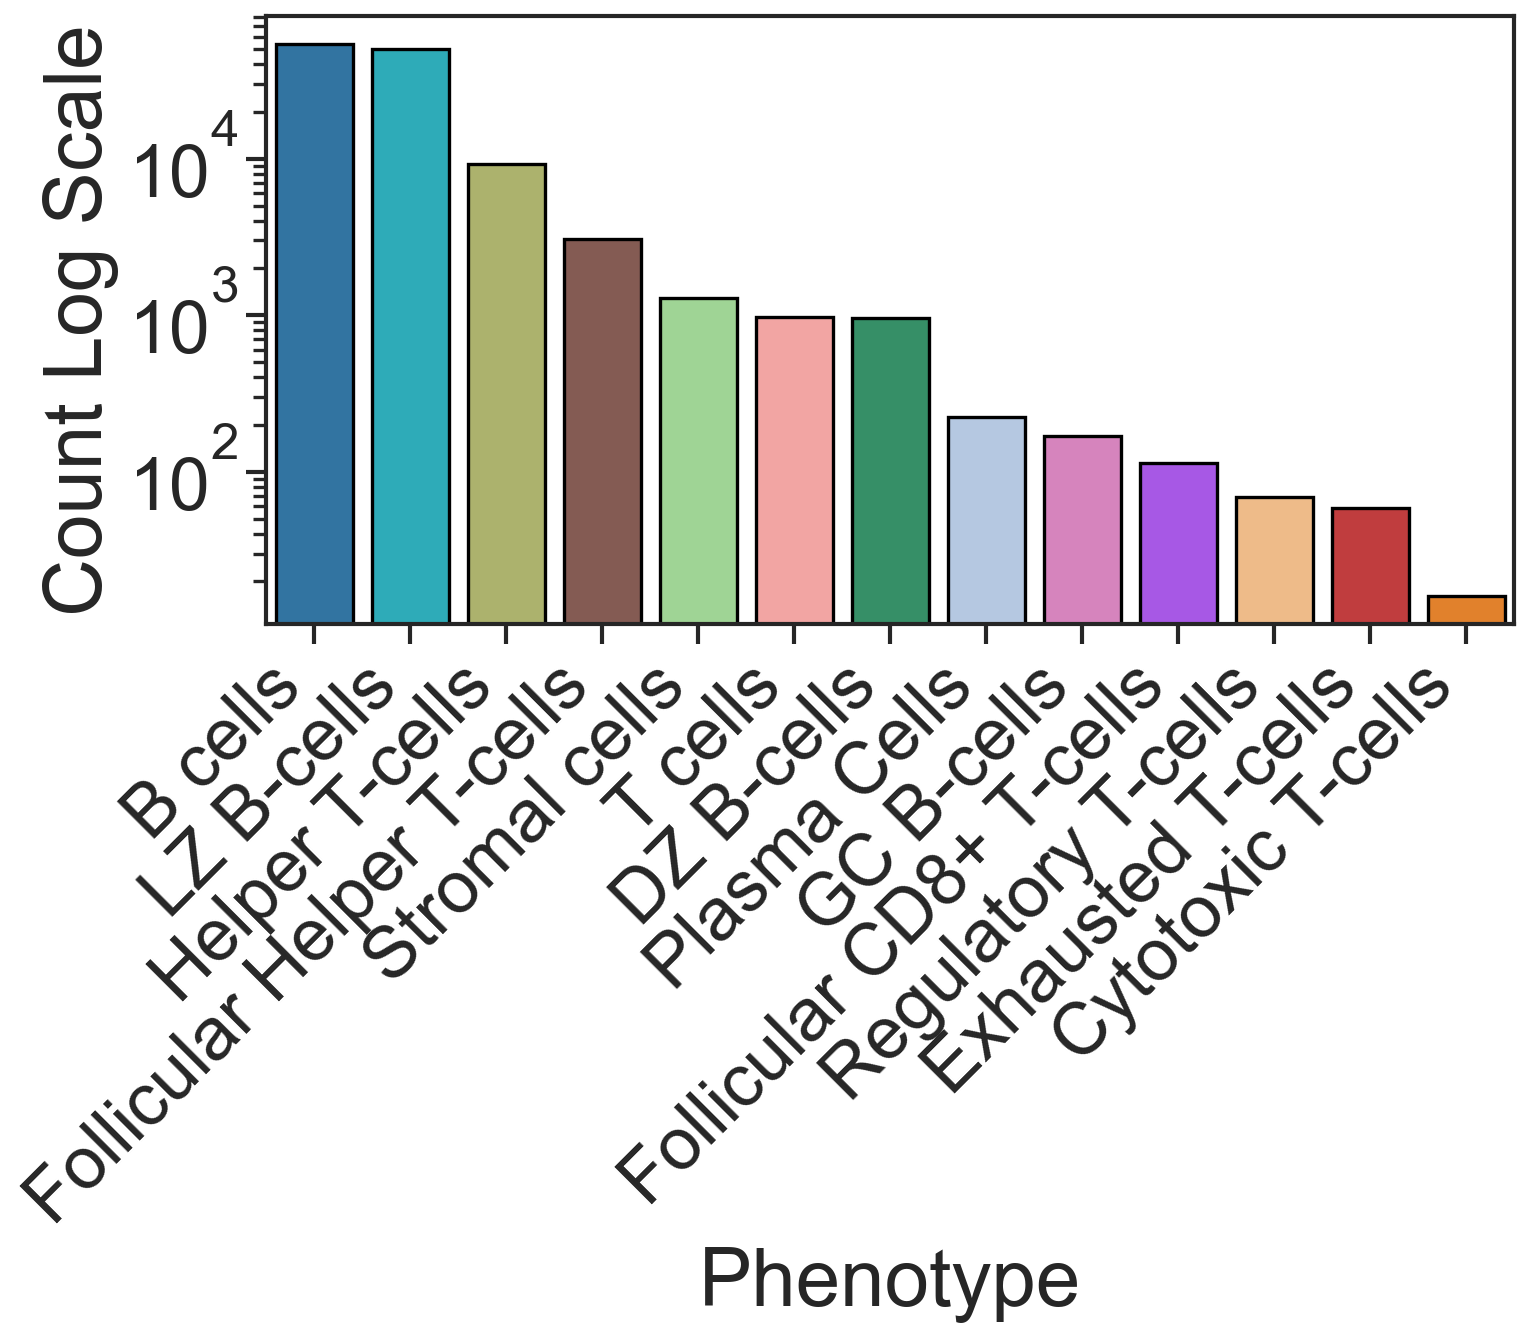

In [192]:
sns.set_style('ticks')
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.barplot(data=df_cluster_count, x=var , y='counts', palette=colors_rgb_dict, edgecolor='k', log=True)
    ax.set_ylabel('Count Log Scale')
    # Fix the legend so it's not on top of the bars.
    plt.xticks(rotation=45, ha='right')